<a href="https://colab.research.google.com/github/Adityaasati/PyTorch-Face-Recognition/blob/main/PyTorch_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import zipfile
import os
from pathlib import Path
import random
import shutil

# Define paths
data_path = Path("data/")
image_path = data_path / "celebrity_face_image_dataset"


# Check if the directory exists, otherwise create it
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download dataset
dataset_url = "https://github.com/Adityaasati/PyTorch-Face-Recognition/raw/refs/heads/main/celebrity_face_image_dataset.zip"
with open(data_path / "celebrity_face_image_dataset.zip", "wb") as f:
    request = requests.get(dataset_url)
    print("Downloading Celebrities Face Image data...")
    f.write(request.content)

# Unzip the downloaded file
with zipfile.ZipFile(data_path / "celebrity_face_image_dataset.zip", "r") as zip_ref:
    print("Unzipping Celebrities Face Image data...")
    zip_ref.extractall(image_path)





data/celebrity_face_image_dataset does not exist, creating one...
Unzipping Celebrities Face Image data...


In [2]:
image_path = image_path/"celebrity_face_image_dataset"
train_dir = image_path/"train"
test_dir = image_path/"test"

In [3]:
import os
import matplotlib.pyplot as plt
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_through_dir(test_dir)

There are 5 directories and 0 images in 'data/celebrity_face_image_dataset/celebrity_face_image_dataset/test'.
There are 0 directories and 20 images in 'data/celebrity_face_image_dataset/celebrity_face_image_dataset/test/Brad Pitt'.
There are 0 directories and 20 images in 'data/celebrity_face_image_dataset/celebrity_face_image_dataset/test/Will Smith'.
There are 0 directories and 20 images in 'data/celebrity_face_image_dataset/celebrity_face_image_dataset/test/Johnny Depp'.
There are 0 directories and 20 images in 'data/celebrity_face_image_dataset/celebrity_face_image_dataset/test/Leonardo DiCaprio'.
There are 0 directories and 20 images in 'data/celebrity_face_image_dataset/celebrity_face_image_dataset/test/Tom Cruise'.


474 474 Tom Cruise


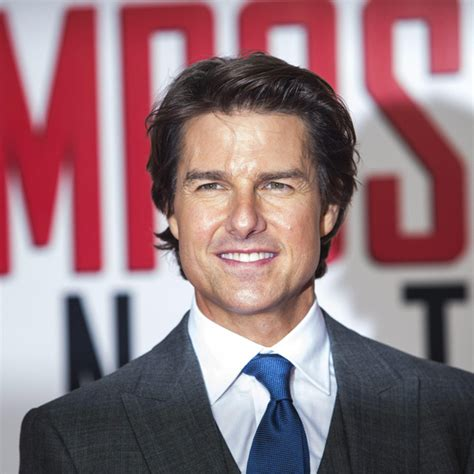

In [5]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_img = random.choice(image_path_list)

image_class = random_img.parent.stem

img=Image.open(random_img)
print(img.height,img.width, image_class)
img

## Now let's convert images to tensors

In [6]:
import torch
device="cuda" if torch.cuda.is_available() else "cpu"

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


data_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                                       transforms.RandomHorizontalFlip(p=0.5),
                                                       transforms.ToTensor()])

In [8]:
data_transform(img).shape

torch.Size([3, 128, 128])

In [9]:
def plot_transformed_images(image_paths, transform,n=3 ):
  random_image_paths = random.sample(image_paths, k=n)
  for image in random_image_paths:
    with Image.open(image) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Shape:{f.size}")
      ax[0].axis(False)

      transformed_img = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_img)
      ax[1].set_title(f"Shape:{transformed_img.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Image of: {image.parent.stem}", fontsize=16)



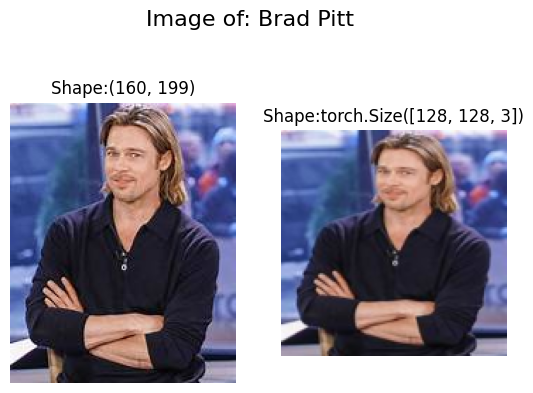

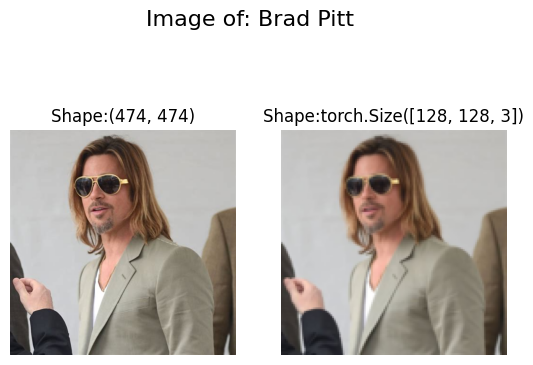

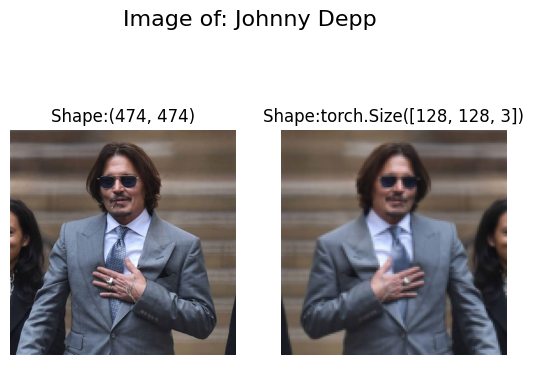

In [10]:
plot_transformed_images(image_path_list,data_transform,3)

In [11]:
from typing import Tuple, Dict, List
from torch.utils.data import Dataset,DataLoader
target_directory = train_dir

class_names = sorted([entry.name for entry in os.scandir(target_directory)])
class_names

['Brad Pitt', 'Johnny Depp', 'Leonardo DiCaprio', 'Tom Cruise', 'Will Smith']

In [12]:
def class_and_idx(target_directory):
  class_names = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

  class_idx = {class_name: i for i,class_name in enumerate(class_names)}

  return class_names,class_idx

In [13]:
class_and_idx(target_directory)

(['Brad Pitt', 'Johnny Depp', 'Leonardo DiCaprio', 'Tom Cruise', 'Will Smith'],
 {'Brad Pitt': 0,
  'Johnny Depp': 1,
  'Leonardo DiCaprio': 2,
  'Tom Cruise': 3,
  'Will Smith': 4})

In [14]:
class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir:str, transform=None):
    self.paths = list(Path(targ_dir).glob("*/*.jpg"))
    self.transform=transform
    self.classes, self.class_to_idx = class_and_idx(targ_dir)
    print(self.class_to_idx,"self.class_to_idx")



  def load_image(self, indx:int) -> Image:
    image_path = self.paths[indx]
    return Image.open(image_path)

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index:int) ->Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx



In [15]:
train_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                      transforms.ToTensor()])
train_data = ImageFolderCustom(targ_dir=train_dir,transform=train_transform)
test_data = ImageFolderCustom(targ_dir=test_dir,transform=test_transform)

# type(train_data),type(test_data)

{'Brad Pitt': 0, 'Johnny Depp': 1, 'Leonardo DiCaprio': 2, 'Tom Cruise': 3, 'Will Smith': 4} self.class_to_idx
{'Brad Pitt': 0, 'Johnny Depp': 1, 'Leonardo DiCaprio': 2, 'Tom Cruise': 3, 'Will Smith': 4} self.class_to_idx


In [16]:
train_data.class_to_idx

{'Brad Pitt': 0,
 'Johnny Depp': 1,
 'Leonardo DiCaprio': 2,
 'Tom Cruise': 3,
 'Will Smith': 4}

In [17]:
test_data.classes

['Brad Pitt', 'Johnny Depp', 'Leonardo DiCaprio', 'Tom Cruise', 'Will Smith']

In [18]:
def display_random_images(dataset:torch.utils.data.Dataset,
                          n:int=3,
                          display_shape:bool=True,
                          classes:List[str]=None):
  if n>10:
    n=10

  random_sample_index = random.sample(range(len(dataset)),k=n)

  plt.figure(figsize=(16,8))

  for i, sample in enumerate(random_sample_index):
    targ_image, label = dataset[sample][0],dataset[sample][1]

    targ_image = targ_image.permute(1, 2, 0)

    plt.subplot(1,n, i+1)
    plt.imshow(targ_image)
    plt.axis(False)
    if classes:
      title = f"Name: {classes[label]}"
      if display_shape:
        title += f"\n shape {targ_image.shape}"
    plt.title(title)



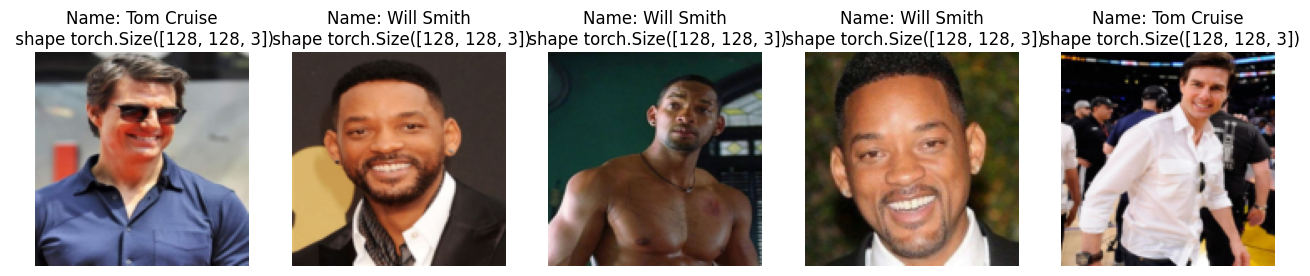

In [19]:
display_random_images(train_data,n=5,classes=train_data.classes)

In [20]:
BATCHES=1
NUM_WORKERS = os.cpu_count()

train_custom_dataloader = DataLoader(train_data,batch_size=BATCHES,shuffle=True,num_workers=NUM_WORKERS)
test_custom_dataloader = DataLoader(test_data,batch_size=BATCHES,shuffle=False,num_workers=NUM_WORKERS)

In [21]:
image_size, label_size = next(iter(train_custom_dataloader))
image_size.shape,label_size.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1]))

### Model 0 (Tiny VGG)

In [22]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*29*29,out_features=output_shape)
    )


  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [23]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8410, out_features=5, bias=True)
  )
)

In [24]:
test_image, test_label = next(iter(train_custom_dataloader))
test_image.shape,test_label.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1]))

In [25]:
model_0(test_image)

tensor([[-0.0301,  0.0255,  0.0211,  0.0126, -0.0197]],
       grad_fn=<AddmmBackward0>)

In [26]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary


summary(model_0,input_size=[1, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 10, 62, 62]           --
│    └─Conv2d: 2-1                       [1, 10, 126, 126]         280
│    └─ReLU: 2-2                         [1, 10, 126, 126]         --
│    └─Conv2d: 2-3                       [1, 10, 124, 124]         910
│    └─ReLU: 2-4                         [1, 10, 124, 124]         --
│    └─MaxPool2d: 2-5                    [1, 10, 62, 62]           --
├─Sequential: 1-2                        [1, 10, 29, 29]           --
│    └─Conv2d: 2-6                       [1, 10, 60, 60]           910
│    └─ReLU: 2-7                         [1, 10, 60, 60]           --
│    └─Conv2d: 2-8                       [1, 10, 58, 58]           910
│    └─ReLU: 2-9                         [1, 10, 58, 58]           --
│    └─MaxPool2d: 2-10                   [1, 10, 29, 29]           --
├─Sequentia

In [27]:
def train_fn(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             optimizer:torch.optim.Optimizer,
             device=device):

  model.train()

  train_loss, train_acc =0,0


  for batch, (X,y) in enumerate(dataloader):

    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss+=loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss,train_acc



In [28]:
def test_fn(model:torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn:torch.nn.Module,
            device=device):

  model.eval()
  test_loss, test_acc=0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      test_pred = model(X)

      loss = loss_fn(test_pred,y)
      test_loss+=loss.item()

      test_labels = test_pred.argmax(dim=1)
      test_acc += (test_labels == y).sum().item()/len(test_pred)

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)

  return test_loss, test_acc




In [29]:
from tqdm.auto import tqdm
from torch import nn
def train_and_test(model:torch.nn.Module,
                   train_dataloader,
                   test_dataloader,
                   optimizer,
                   loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
                   epochs:int=5,
                   device=device
                   ):

  results = {"train_acc":[],
             "train_loss":[],
             "test_acc":[],
             "test_loss":[]
             }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc  = train_fn(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                      device=device)
    test_loss, test_acc  = test_fn(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train acc: {train_acc} | Test Loss: {test_loss} | Test acc: {test_acc}")
    results['train_acc'].append(train_acc)
    results['train_loss'].append(train_loss)
    results['test_acc'].append(test_acc)
    results['test_loss'].append(test_loss)

  return results





In [30]:
len(train_custom_dataloader),test_custom_dataloader

(400, <torch.utils.data.dataloader.DataLoader at 0x7ef409e8e6d0>)

In [31]:
from timeit import default_timer as timer

NUM_EPOCHS=5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.001)

start = timer()
model_0_results= train_and_test(model=model_0,
                              train_dataloader=train_custom_dataloader,
                              test_dataloader=test_custom_dataloader,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=NUM_EPOCHS)

end_timer = timer()

print(f"Time taken: {end_timer - start:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.6437530890107155 | Train acc: 0.1525 | Test Loss: 1.6094810962677002 | Test acc: 0.2
Epoch: 1 | Train Loss: 1.6103910875320435 | Train acc: 0.2025 | Test Loss: 1.609464168548584 | Test acc: 0.2
Epoch: 2 | Train Loss: 1.6102976283431054 | Train acc: 0.17 | Test Loss: 1.609452199935913 | Test acc: 0.2
Epoch: 3 | Train Loss: 1.6103334799408913 | Train acc: 0.1875 | Test Loss: 1.609447717666626 | Test acc: 0.2
Epoch: 4 | Train Loss: 1.6104600483179092 | Train acc: 0.2 | Test Loss: 1.6094470977783204 | Test acc: 0.2
Time taken: 71.947


In [32]:
model_0_results

{'train_acc': [0.1525, 0.2025, 0.17, 0.1875, 0.2],
 'train_loss': [1.6437530890107155,
  1.6103910875320435,
  1.6102976283431054,
  1.6103334799408913,
  1.6104600483179092],
 'test_acc': [0.2, 0.2, 0.2, 0.2, 0.2],
 'test_loss': [1.6094810962677002,
  1.609464168548584,
  1.609452199935913,
  1.609447717666626,
  1.6094470977783204]}

In [33]:
def loss_curves_plot(result: Dict[str,List[float]]):
  loss = result['train_loss']
  test_loss = result['test_loss']

  accuracy = result['train_acc']
  test_accuracy = result['test_acc']

  epochs = range(len(result['train_loss']))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="Train Accuracy")
  plt.plot(epochs,test_accuracy,label="Test Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

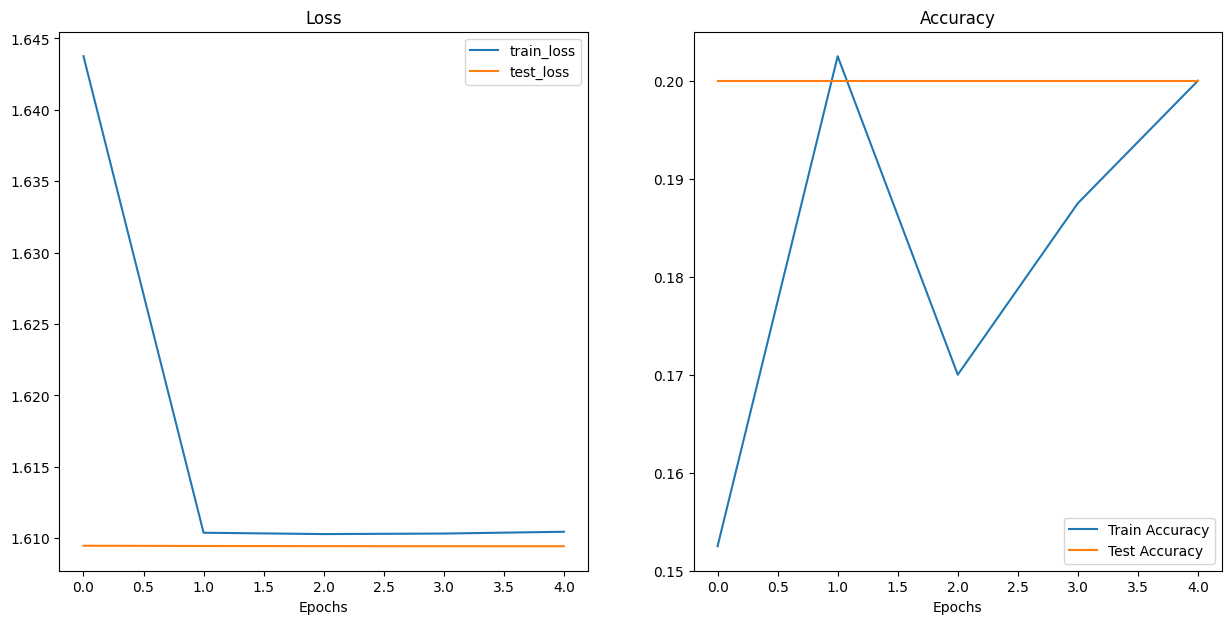

In [34]:
loss_curves_plot(model_0_results)

## Model 1 with Data Augmentation

In [35]:
from torchvision import datasets, transforms
import os
from torch.utils.data import DataLoader

train_transform_trivial = transforms.Compose([transforms.Resize(size=(128,128)),
                                                                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                                transforms.ToTensor()])
test_transform_simple = transforms.Compose([transforms.Resize(size=(128,128)),
                                                                transforms.ToTensor()

                                              ])

train_augmented_data = datasets.ImageFolder(root=train_dir,
                                            transform = train_transform_trivial)

test_simple_data = datasets.ImageFolder(root=test_dir,
                                            transform = test_transform_simple)

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_augmented_dataloader = DataLoader(dataset=train_augmented_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_simple_dataloader = DataLoader(dataset=test_simple_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

model_1 = TinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_augmented_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8410, out_features=5, bias=True)
  )
)

In [36]:
NUM_EPOCHS=5

loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),lr=0.001)

start_time=timer()

model_1_results = train_and_test(
    model=model_1,
    train_dataloader=train_augmented_dataloader,
    test_dataloader=test_simple_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device
)

end_time=timer()
print(f"Total time taken: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.633141251710745 | Train acc: 0.18269230769230768 | Test Loss: 1.6076017320156097 | Test acc: 0.1640625
Epoch: 1 | Train Loss: 1.6128220099669237 | Train acc: 0.21875 | Test Loss: 1.6030979454517365 | Test acc: 0.3515625
Epoch: 2 | Train Loss: 1.6059206632467418 | Train acc: 0.23317307692307693 | Test Loss: 1.5914764404296875 | Test acc: 0.359375
Epoch: 3 | Train Loss: 1.600730061531067 | Train acc: 0.2548076923076923 | Test Loss: 1.555491864681244 | Test acc: 0.4921875
Epoch: 4 | Train Loss: 1.5980072846779456 | Train acc: 0.25721153846153844 | Test Loss: 1.5526296496391296 | Test acc: 0.171875
Total time taken: 60.905 seconds


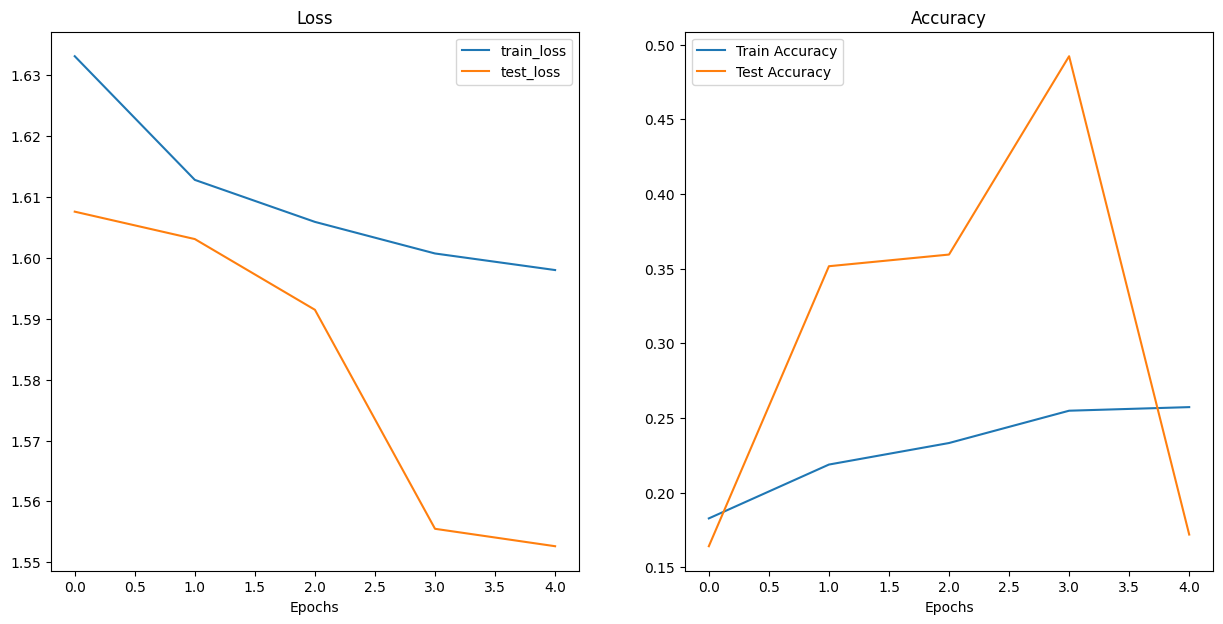

In [37]:
loss_curves_plot(model_1_results)

### Augmented model with 9 epochs

In [38]:
NUM_EPOCHS=9

loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),lr=0.001)

start_time=timer()

model_2_results = train_and_test(
    model=model_1,
    train_dataloader=train_augmented_dataloader,
    test_dataloader=test_simple_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device
)

end_time=timer()
print(f"Total time taken: {end_time-start_time:.3f} seconds")

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.567609163431021 | Train acc: 0.29086538461538464 | Test Loss: 1.5510006546974182 | Test acc: 0.2265625
Epoch: 1 | Train Loss: 1.5628698330659132 | Train acc: 0.3076923076923077 | Test Loss: 1.4242454171180725 | Test acc: 0.5078125
Epoch: 2 | Train Loss: 1.530787202028128 | Train acc: 0.3389423076923077 | Test Loss: 1.4291050732135773 | Test acc: 0.4765625
Epoch: 3 | Train Loss: 1.5607691544752855 | Train acc: 0.3269230769230769 | Test Loss: 1.4212486445903778 | Test acc: 0.4921875
Epoch: 4 | Train Loss: 1.516681120945857 | Train acc: 0.3269230769230769 | Test Loss: 1.488828182220459 | Test acc: 0.3984375
Epoch: 5 | Train Loss: 1.522878463451679 | Train acc: 0.3245192307692308 | Test Loss: 1.4292472004890442 | Test acc: 0.4296875
Epoch: 6 | Train Loss: 1.4654755684045644 | Train acc: 0.3701923076923077 | Test Loss: 1.4440523386001587 | Test acc: 0.390625
Epoch: 7 | Train Loss: 1.4701901582571177 | Train acc: 0.4110576923076923 | Test Loss: 1.5180872678756714 | T

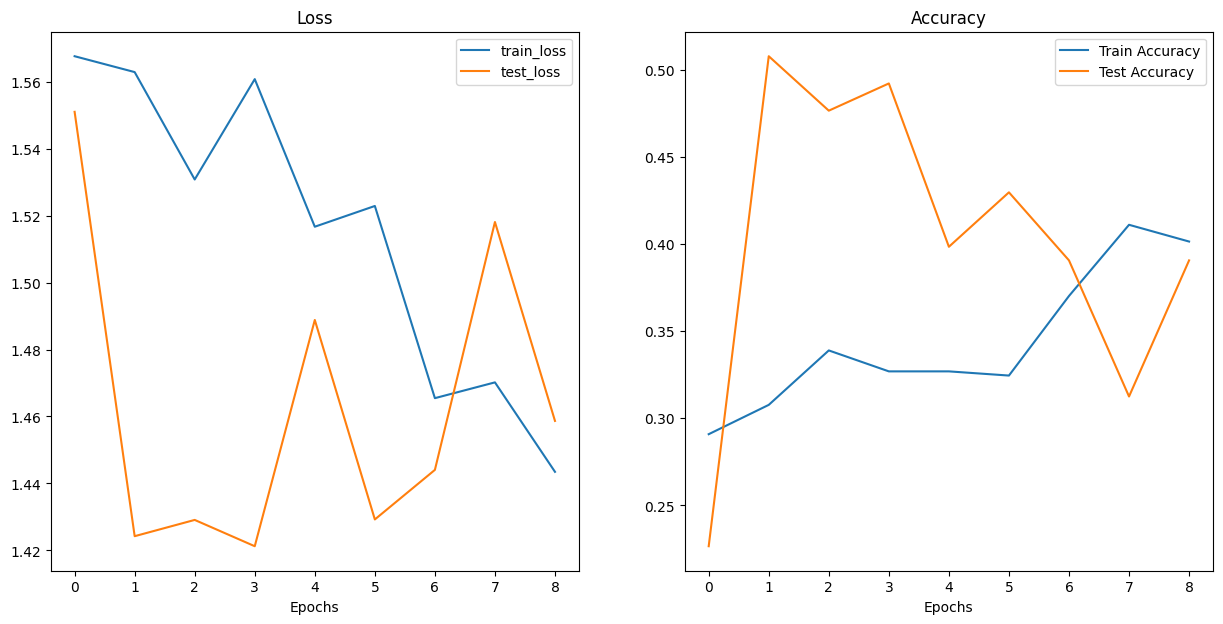

In [39]:
loss_curves_plot(model_2_results)

In [40]:
### Comparisons

In [41]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)
model_0_df,model_2_df

(   train_acc  train_loss  test_acc  test_loss
 0     0.1525    1.643753       0.2   1.609481
 1     0.2025    1.610391       0.2   1.609464
 2     0.1700    1.610298       0.2   1.609452
 3     0.1875    1.610333       0.2   1.609448
 4     0.2000    1.610460       0.2   1.609447,
    train_acc  train_loss  test_acc  test_loss
 0   0.290865    1.567609  0.226562   1.551001
 1   0.307692    1.562870  0.507812   1.424245
 2   0.338942    1.530787  0.476562   1.429105
 3   0.326923    1.560769  0.492188   1.421249
 4   0.326923    1.516681  0.398438   1.488828
 5   0.324519    1.522878  0.429688   1.429247
 6   0.370192    1.465476  0.390625   1.444052
 7   0.411058    1.470190  0.312500   1.518087
 8   0.401442    1.443471  0.390625   1.458676)

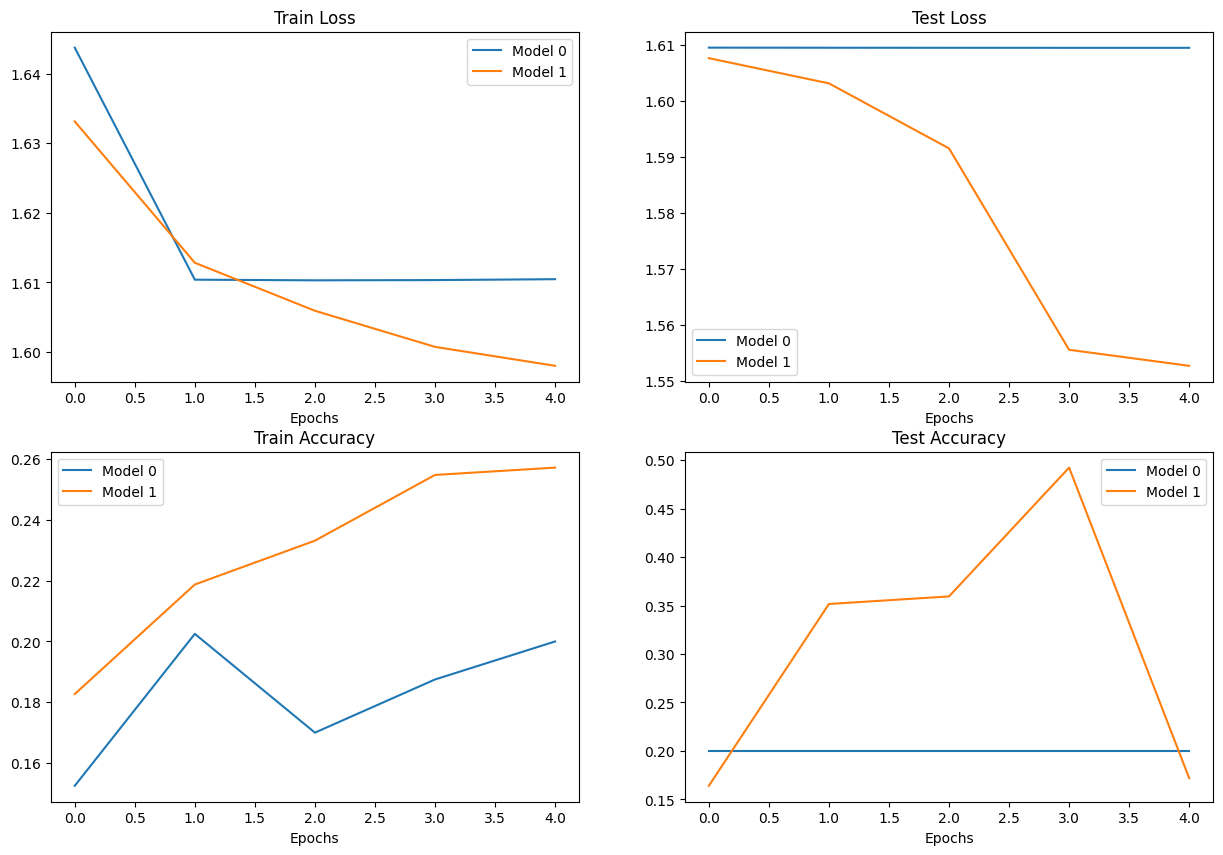

In [42]:
plt.figure(figsize=(15,10))

epochs=range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title ("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title ("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.title ("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.title ("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Exciting part!!
### Making a prediction on a custom image

In [43]:


import requests
from pathlib import Path
data_path = Path("data/")

image_urls = [
    "https://raw.githubusercontent.com/Adityaasati/PyTorch-Face-Recognition/main/Images/Johnny-Depp.png",
    "https://raw.githubusercontent.com/Adityaasati/PyTorch-Face-Recognition/main/Images/Leonardo-DiCaprio.png",
    "https://raw.githubusercontent.com/Adityaasati/PyTorch-Face-Recognition/main/Images/Brad-Pitt.png",
    "https://raw.githubusercontent.com/Adityaasati/PyTorch-Face-Recognition/main/Images/Tom-Cruise.png",
    "https://raw.githubusercontent.com/Adityaasati/PyTorch-Face-Recognition/main/Images/Will-Smith.png"
]

# List of corresponding paths to save images locally
image_paths = [
    data_path / "Johnny-Depp.png",
    data_path / "Leonardo-DiCaprio.png",
    data_path / "Brad-Pitt.png",
    data_path / "Tom-Cruise.png",
    data_path / "Will-Smith.png"
]

# Loop through each image URL and path
for url, path in zip(image_urls, image_paths):
    if not path.is_file():  # If the file does not already exist
        with open(path, "wb") as f:
            request = requests.get(url)
            print(f"Downloading {path}...")
            f.write(request.content)
    else:
        print(f"{path} already exists, skipping download...")


(np.float64(-0.5), np.float64(696.5), np.float64(879.5), np.float64(-0.5))

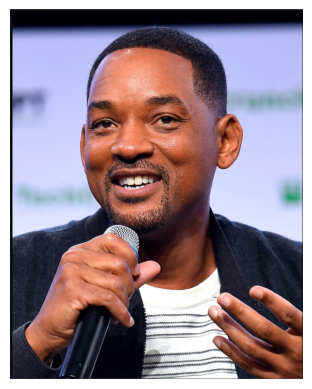

In [44]:
import torchvision

custom_image1_uint8 = torchvision.io.read_image(str(path)).type(torch.float32) / 255.
plt.imshow(custom_image1_uint8.permute(1,2,0))
plt.axis(False)

## As a function

In [45]:
def predictions_plt(model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str]=None,
                    transform=None,
                    device=device):

  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
  target_image = target_image.clamp(0.0, 1.0)
  if transform:
    target_image= transform(target_image)[:3]


  model.to(device)

  model.eval()

  with torch.inference_mode():
    pred_image = model(target_image.unsqueeze(0).to(device))

  custom_image_probs = torch.softmax(pred_image, dim=1)

  custom_image_labels= torch.argmax(custom_image_probs, dim=1)

  return target_image, custom_image_labels, custom_image_probs






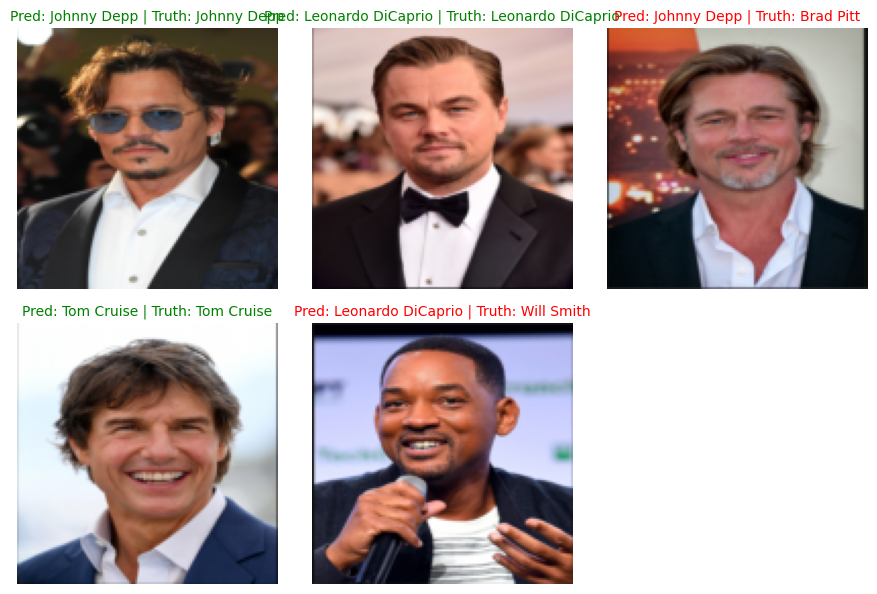

In [46]:
custom_image_transform = transforms.Compose([transforms.Resize(size=(128, 128))])

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, image_path in enumerate(image_paths):
    plt.subplot(nrows, ncols, i + 1)

    target_image, custom_image_labels, custom_image_probs = predictions_plt(model=model_1,
                                                                            image_path=image_path,
                                                                            class_names=class_names,
                                                                            transform=custom_image_transform,
                                                                            device=device)

    truth_label = image_path.stem
    truth_label = truth_label.replace("-"," ")

    pred_label = class_names[custom_image_labels.cpu()]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label.lower().strip() == truth_label.lower().strip():
      plt.title(title_text, fontsize=10, c="g")  # Green if correct
    else:
      plt.title(title_text, fontsize=10, c="r")

    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    plt.axis(False)

plt.tight_layout()
plt.show()

In [47]:
truth_label.replace("-"," "),pred_label

('Will Smith', 'Leonardo DiCaprio')

In [48]:
truth_label = image_path.stem
truth_label = truth_label.replace("-"," ")
truth_label

'Will Smith'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
pwd

'/content'

In [55]:
pwd

'/content'